In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
import joblib
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

pd.set_option('display.max_columns', None)

# Data Load




In [2]:
from google.colab import drive
drive.mount('/content/drive')
raw_df = pd.read_csv('/content/drive/MyDrive/Machine Learning/Data/weatherAUS.csv')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder
from typing import Dict, Any, Tuple

def drop_na_values(df: pd.DataFrame, columns: list) -> pd.DataFrame:
    """
    Drop rows with NA values in the specified columns.

    Args:
        df (pd.DataFrame): The raw dataframe.
        columns (list): List of columns to check for NA values.

    Returns:
        pd.DataFrame: DataFrame with NA values dropped.
    """
    return df.dropna(subset=columns)

def split_data_by_year(df: pd.DataFrame, year_col: str) -> Dict[str, pd.DataFrame]:
    """
    Split the dataframe into training, validation, and test sets based on the year.

    Args:
        df (pd.DataFrame): The raw dataframe.
        year_col (str): The column containing year information.

    Returns:
        Dict[str, pd.DataFrame]: Dictionary containing the train, validation, and test dataframes.
    """
    year = pd.to_datetime(df[year_col]).dt.year
    train_df = df[year < 2015]
    val_df = df[year == 2015]
    test_df = df[year > 2015]
    return {'train': train_df, 'val': val_df, 'test': test_df}

def create_inputs_targets(df_dict: Dict[str, pd.DataFrame], input_cols: list, target_col: str) -> Dict[str, Any]:
    """
    Create inputs and targets for training, validation, and test sets.

    Args:
        df_dict (Dict[str, pd.DataFrame]): Dictionary containing the train, validation, and test dataframes.
        input_cols (list): List of input columns.
        target_col (str): Target column.

    Returns:
        Dict[str, Any]: Dictionary containing inputs and targets for train, val, and test sets.
    """
    data = {}
    for split in df_dict:
        data[f'{split}_inputs'] = df_dict[split][input_cols].copy()
        data[f'{split}_targets'] = df_dict[split][target_col].copy()
    return data

def impute_missing_values(data: Dict[str, Any], numeric_cols: list) -> IterativeImputer:
    """
    Impute missing numeric values using IterativeImputer that estimates each feature from all the others.

    Args:
        data (Dict[str, Any]): Dictionary containing inputs and targets for train, val, and test sets.
        numeric_cols (list): List of numerical columns.

    Returns:
         IterativeImputer: Fitted imputer used for transforming columns in the dataset.
    """
    imputer = IterativeImputer(max_iter=10, random_state=42).fit(data['train_inputs'][numeric_cols])
    for split in ['train', 'val', 'test']:
          data[f'{split}_inputs'][numeric_cols] = imputer.transform(data[f'{split}_inputs'][numeric_cols])

    return imputer

def scale_numeric_features(data: Dict[str, Any], numeric_cols: list) -> MinMaxScaler:
    """
    Scale numeric features using MinMaxScaler.

    Args:
        data (Dict[str, Any]): Dictionary containing inputs and targets for train, val, and test sets.
        numeric_cols (list): List of numerical columns.

    Returns:
        MinMaxScaler: Fitted scaler used to transform the numerical columns in the dataset.
    """
    scaler = MinMaxScaler().fit(data['train_inputs'][numeric_cols])
    for split in ['train', 'val', 'test']:
        data[f'{split}_inputs'][numeric_cols] = scaler.transform(data[f'{split}_inputs'][numeric_cols])

    return scaler

def encode_categorical_features(data: Dict[str, Any], categorical_cols: list) -> Tuple[OneHotEncoder, LabelEncoder]:
    """
    One-hot encode categorical features.

    Args:
        data (Dict[str, Any]): Dictionary containing inputs and targets for train, val, and test sets.
        categorical_cols (list): List of categorical columns.

    Returns:
        OneHotEncoder, LabelEncoder: Fitted one-hot encoder for input features and label encoder for the target variable.
    """
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore').fit(data['train_inputs'][categorical_cols])
    encoded_cols = list(encoder.get_feature_names_out(categorical_cols))
    for split in ['train', 'val', 'test']:
        encoded = encoder.transform(data[f'{split}_inputs'][categorical_cols])
        data[f'{split}_inputs'] = pd.concat([data[f'{split}_inputs'], pd.DataFrame(encoded, columns=encoded_cols, index=data[f'{split}_inputs'].index)], axis=1)
        data[f'{split}_inputs'].drop(columns=categorical_cols, inplace=True)
    data['encoded_cols'] = encoded_cols

    label_encoder = LabelEncoder()
    label_encoder.fit(data['train_targets'])
    for split in ['train', 'val', 'test']:
         data[f'{split}_targets'] = label_encoder.transform(data[f'{split}_targets'])

    return encoder, label_encoder


def preprocess_data(raw_df: pd.DataFrame) -> Tuple[Dict[str, Any], IterativeImputer, MinMaxScaler, OneHotEncoder, LabelEncoder, list, list, list, str]:
    """
    Preprocess the raw dataframe.

    Args:
        raw_df (pd.DataFrame): The raw dataframe.

    Returns:
        Tuple: Contains the following elements:
            - Dictionary containing processed inputs and targets for train, val, and test sets.
            - Fitted IterativeImputer used for missing value imputation.
            - Fitted MinMaxScaler used for scaling numeric features.
            - Fitted OneHotEncoder used for encoding categorical features.
            - Fitted LabelEncoder used for encoding the target variable.
            - List of numeric columns.
            - List of categorical columns.
            - List of input columns used for training.
            - Target column.
    """
    raw_df = drop_na_values(raw_df, ['RainToday', 'RainTomorrow'])
    for col in raw_df.select_dtypes(include=['object']).columns:
        raw_df[col] = raw_df[col].astype('category')
    split_dfs = split_data_by_year(raw_df, 'Date')
    input_cols = list(raw_df.columns)[1:-1]
    target_col = 'RainTomorrow'
    data = create_inputs_targets(split_dfs, input_cols, target_col)

    numeric_cols = data['train_inputs'].select_dtypes(include=np.number).columns.tolist()
    categorical_cols = data['train_inputs'].select_dtypes('category').columns.tolist()
    imputer = impute_missing_values(data, numeric_cols)
    scaler = scale_numeric_features(data, numeric_cols)
    encoder, label_encoder = encode_categorical_features(data, categorical_cols)

    # Extract X_train, X_val, X_test
    X_train = data['train_inputs'][numeric_cols + data['encoded_cols']]
    X_val = data['val_inputs'][numeric_cols + data['encoded_cols']]
    X_test = data['test_inputs'][numeric_cols + data['encoded_cols']]

    data_dict = {
        'train_X': X_train,
        'train_y': data['train_targets'],
        'val_X': X_val,
        'val_y': data['val_targets'],
        'test_X': X_test,
        'test_y': data['test_targets'],
    }

    return data_dict, imputer, scaler, encoder, label_encoder, numeric_cols, categorical_cols, input_cols, target_col

In [ ]:
data, imputer, scaler, encoder, label_encoder, numeric_cols, categorical_cols, input_cols, target_col = preprocess_data(raw_df)

In [5]:
X_train = data['train_X']
train_targets = data['train_y']
X_val = data['val_X']
val_targets = data['val_y']
X_test = data['test_X']
test_targets = data['test_y']

In [6]:
# Find the best threshold to predict the positive class to achieve the best F1
def get_best_threshold(model, val_X, val_y):
  y_probs = model.predict_proba(val_X)[:, 1]  # Get probabilities for the positive class
  f1s = []
  thresholds = np.arange(0.0, 1.0, 0.025)  # Create a range of thresholds
  for thresh in thresholds:
    y_pred_thresh = (y_probs >= thresh).astype(int)
    f1s.append(f1_score(val_y, y_pred_thresh))

  best_threshold = thresholds[np.argmax(f1s)]
  return best_threshold

In [7]:
# Compute precision, recall, F1, build confusion matrix
def compute_metrics(model, inputs, targets, name='', threshold=0.5):
  # Compute predictions based on custom threshold
  preds_probas = model.predict_proba(inputs)[:,1]
  preds = (preds_probas >= threshold).astype(int)
  # Compute precision, recall, F1
  precision = precision_score(targets, preds)
  recall = recall_score(targets, preds)
  f1 = f1_score(targets, preds)

  print("Precision score: {:.2f}".format(precision))
  print("Recall score: {:.2f}".format(recall))
  print("F1 score: {:.2f}".format(f1))

  # Build confusion matrix
  cm_abs = confusion_matrix(targets, preds)
  cm_percentage = confusion_matrix(targets, preds, normalize='true')

  plt.figure()
  ax = sns.heatmap(cm_percentage, annot=True)

  threshold = cm_abs.max() / 2
  for i in range(cm_abs.shape[0]):
    for j in range(cm_abs.shape[1]):
      ax.text(j + 0.5, i + 0.6, f'\n({cm_abs[i, j]})',
              ha='center', va='center', fontsize=10,
              color="white" if cm_abs[i, j] < threshold else "black")

  plt.xlabel('Prediction')
  plt.ylabel('Target')
  plt.title('{} Confusion Matrix'.format(name))
  plt.show()

In [14]:
from sklearn.metrics import roc_curve, auc

def compute_auroc_and_build_roc(model, inputs, targets, name=''):
  # Predict probabilities
  y_pred_proba = model.predict_proba(inputs)[:, 1]

  # Compute ROC curve
  fpr, tpr, thresholds = roc_curve(targets, y_pred_proba, pos_label=1)

    # Compute AUROC
  roc_auc = auc(fpr, tpr)
  print(f'AUROC for {name}: {roc_auc:.2f}')

  # Plot the ROC curve
  plt.figure()
  plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(f'Receiver Operating Characteristic (ROC) Curve for {name}')
  plt.legend(loc="lower right")
  plt.show()

# Random Forest

In [16]:
# Random Forest params for Randomized Search
params_rf = {
    'max_depth': [5, 10, 15],
    'n_estimators': [200, 300, 500],
    'min_samples_split': [10, 20, 50],
    'min_samples_leaf': [4, 10, 20],
    'max_features': [0.3, 0.5, 0.7],  # Fraction of features to consider at each split
    'max_samples': [0.7, 0.8, 0.9],   # Fraction of samples to be used for each tree
}

cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [17]:
# Define RandomizedSearchCV
rf_search = RandomizedSearchCV(
    RandomForestClassifier(random_state=42),
    params_rf,
    cv=cv_strategy,
    scoring="f1",
    random_state=42,
    refit=True
)

In [18]:
# Fit on trainig data
rf_search.fit(X_train, train_targets)

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=RandomForestClassifier(random_state=42),
                   param_distributions={'max_depth': [5, 10, 15],
                                        'max_features': [0.3, 0.5, 0.7],
                                        'max_samples': [0.7, 0.8, 0.9],
                                        'min_samples_leaf': [4, 10, 20],
                                        'min_samples_split': [10, 20, 50],
                                        'n_estimators': [200, 300, 500]},
                   random_state=42, scoring='f1')

In [19]:
# Get the best model
rf = rf_search.best_estimator_

In [20]:
# Train the best model on the training data
rf.fit(X_train, train_targets)

RandomForestClassifier(max_depth=15, max_features=0.3, max_samples=0.8,
                       min_samples_leaf=4, min_samples_split=10,
                       n_estimators=500, random_state=42)

In [21]:
rf_threshold = get_best_threshold(rf, X_val, val_targets)
print("Best threshold:", rf_threshold)

Best threshold: 0.30000000000000004


Precision score: 0.91
Recall score: 0.63
F1 score: 0.75


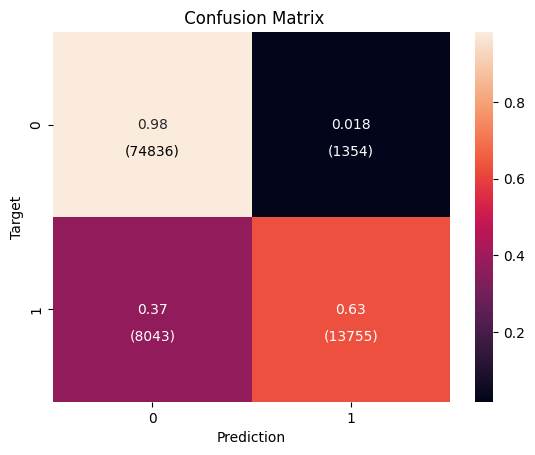

Precision score: 0.77
Recall score: 0.41
F1 score: 0.54


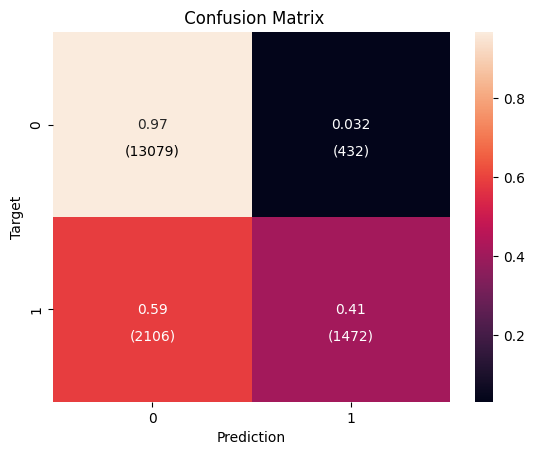

In [22]:
# Calculate the metrics
compute_metrics(rf, X_train, train_targets, threshold=rf_threshold)
compute_metrics(rf, X_val, val_targets, threshold=rf_threshold)

# XGB

In [8]:
# Function that specifies objective
def objective(model_class, param_space, params, **model_specific_params):
    # Convert hyperopt params to the correct types if necessary
    model_params = {key: int(value) if key in param_space['int_params'] else value for key, value in params.items()}

    # Initialize the model
    model = model_class(**model_params, **model_specific_params, random_state=42)

    # Fit the model
    try:
        model.fit(X_train, train_targets, eval_set=[(X_val, val_targets)], verbose=False)
    except TypeError:
        model.fit(X_train, train_targets, eval_set=[(X_val, val_targets)])

    # Compute F1
    preds = model.predict(X_val)
    f1 = f1_score(val_targets, preds)

    return {'loss': -f1, 'status': STATUS_OK}

# Wrapper function for hyperopt for XGB
def hyperopt_objective_XGB(params):
    return objective(XGBClassifier, param_space, params, enable_categorical=True)

# Function to find best hyperparameters
def optimize_hyperopt_params(objective, space, int_params, max_evals):
    best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=max_evals, trials=Trials())
    # Convert hyperparameter values to final types
    for key in int_params:
      best[key] = int(best[key])

    print("Best hyperparameters: ", best)

    return best


In [50]:
param_space = {
  'params': {
      'n_estimators': hp.quniform('n_estimators', 100, 500, 50),
      'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
      'max_depth': hp.quniform('max_depth', 4, 10, 1),
      'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
      'subsample': hp.uniform('subsample', 0.5, 0.9),
      'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 0.9),
      'gamma': hp.uniform('gamma', 0.0, 0.5),
      'reg_alpha': hp.uniform('reg_alpha', 0, 5),
      'reg_lambda': hp.uniform('reg_lambda', 1, 10)
},
    'int_params': ['n_estimators', 'max_depth', 'min_child_weight']  # List of params that need to be converted to int
}

# Find best hyperparameters for XGB Classifier
best = optimize_hyperopt_params(hyperopt_objective_XGB, param_space['params'], param_space['int_params'], max_evals=50)


100%|██████████| 50/50 [25:30<00:00, 30.61s/trial, best loss: -0.6014613085353703]
Best hyperparameters:  {'colsample_bytree': 0.8369774496709625, 'gamma': 0.13609335700152292, 'learning_rate': 0.1754847914317739, 'max_depth': 8, 'min_child_weight': 10, 'n_estimators': 400, 'reg_alpha': 0.6130377773392056, 'reg_lambda': 7.430490159193916, 'subsample': 0.8868541833334166}


In [29]:
# Final model with the best parameters
xgb = XGBClassifier(
    n_estimators=best['n_estimators'],
    learning_rate=best['learning_rate'],
    max_depth=best['max_depth'],
    min_child_weight=best['min_child_weight'],
    subsample=best['subsample'],
    colsample_bytree=best['colsample_bytree'],
    gamma=best['gamma'],
    reg_alpha=best['reg_alpha'],
    reg_lambda=best['reg_lambda'],
    random_state=42
)

xgb.fit(X_train, train_targets)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:25:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.4816616651140746, device=None,
              early_stopping_rounds=None, enable_categorical=True,
              eval_metric=None, feature_types=None, gamma=0.35729404050591895,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.049794710455525214,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=11, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [53]:
xgb_threshold = get_best_threshold(xgb, X_val, val_targets)
print("Best threshold:", xgb_threshold)

Best threshold: 0.275


Precision score: 0.60
Recall score: 0.75
F1 score: 0.66


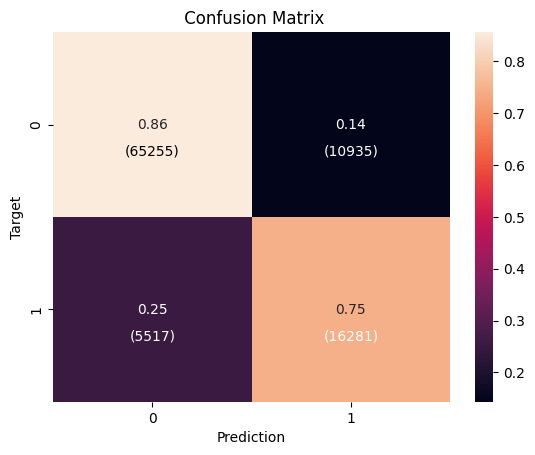

Precision score: 0.60
Recall score: 0.66
F1 score: 0.63


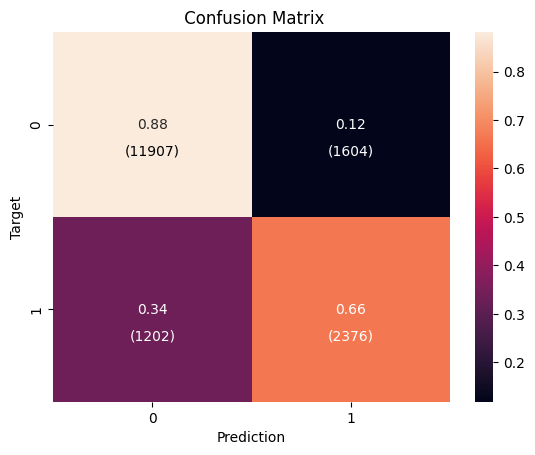

In [54]:
compute_metrics(xgb, X_train, train_targets, threshold=xgb_threshold)
compute_metrics(xgb, X_val, val_targets, threshold=xgb_threshold)

# LightGBM

In [ ]:
# Wrapper function for hyperopt for LGBM
def hyperopt_objective_lgbm(params):
    return objective(LGBMClassifier, param_space, params)

param_space = {
    'params': {
      'n_estimators': hp.quniform('n_estimators', 100, 500, 50),
      'learning_rate': hp.uniform('learning_rate', 0.01, 0.1),
      'max_depth': hp.quniform('max_depth', 4, 12, 1),
      'num_leaves': hp.quniform('num_leaves', 20, 100, 5),
      'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
      'subsample': hp.uniform('subsample', 0.5, 0.9),
      'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 0.9),
      'reg_alpha': hp.uniform('reg_alpha', 0.0, 5.0),
      'reg_lambda': hp.uniform('reg_lambda', 0.0, 10.0),
      'min_split_gain': hp.uniform('min_split_gain', 0.0, 0.5)
}
,
    'int_params': ['n_estimators', 'max_depth', 'num_leaves']  # List of params that need to be converted to int
}

# Find best hyperparameters for LGBM Classifier
best_lgbm = optimize_hyperopt_params(hyperopt_objective_lgbm, param_space['params'], param_space['int_params'], max_evals=50)


In [ ]:
# Final model with the best parameters
lgbm = LGBMClassifier(
    n_estimators=best_lgbm['n_estimators'],
    learning_rate=best_lgbm['learning_rate'],
    max_depth=best_lgbm['max_depth'],
    num_leaves=best_lgbm['num_leaves'],
    min_child_weight=best_lgbm['min_child_weight'],
    subsample=best_lgbm['subsample'],
    colsample_bytree=best_lgbm['colsample_bytree'],
    reg_alpha=best_lgbm['reg_alpha'],
    reg_lambda=best_lgbm['reg_lambda'],
    min_split_gain=best_lgbm['min_split_gain'],
    #cat_feature=cat_col_indices,
    random_state=42
)

lgbm.fit(X_train, train_targets)

In [11]:
lgbm_threshold = get_best_threshold(lgbm, X_val, val_targets)
print("Best threshold:", lgbm_threshold)

Best threshold: 0.30000000000000004


Precision score: 0.73
Recall score: 0.85
F1 score: 0.79


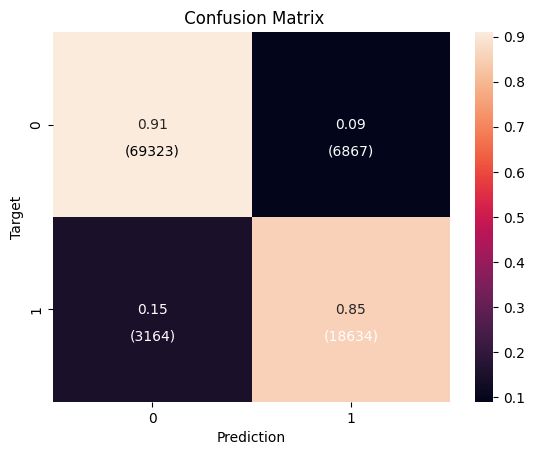

Precision score: 0.63
Recall score: 0.69
F1 score: 0.65


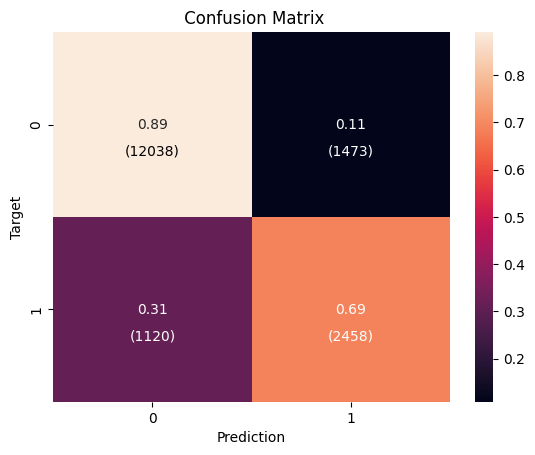

In [12]:
compute_metrics(lgbm, X_train, train_targets, threshold=lgbm_threshold)
compute_metrics(lgbm, X_val, val_targets, threshold=lgbm_threshold)

# Model Comparison on Test Dataset

AUROC for Random Forest Validation: 0.85


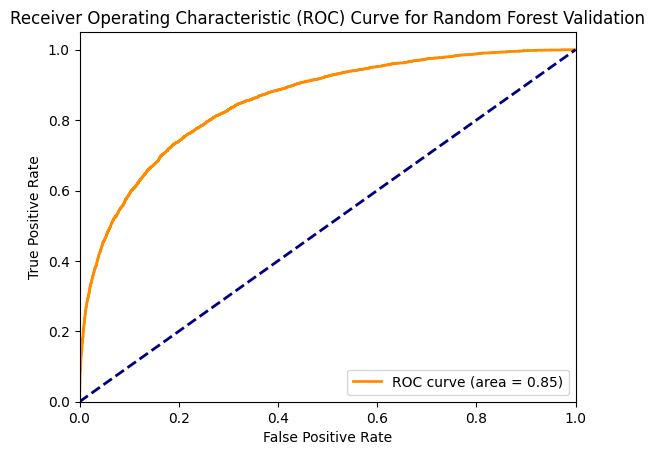

In [68]:
compute_auroc_and_build_roc(rf, X_test, test_targets, name='Random Forest Validation')

AUROC for XGB Validation: 0.86


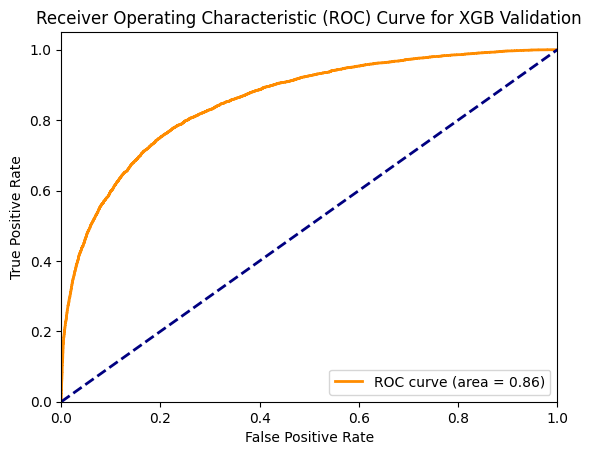

In [69]:
compute_auroc_and_build_roc(xgb, X_test, test_targets, name='XGB Validation')

AUROC for LGBM Validation: 0.88


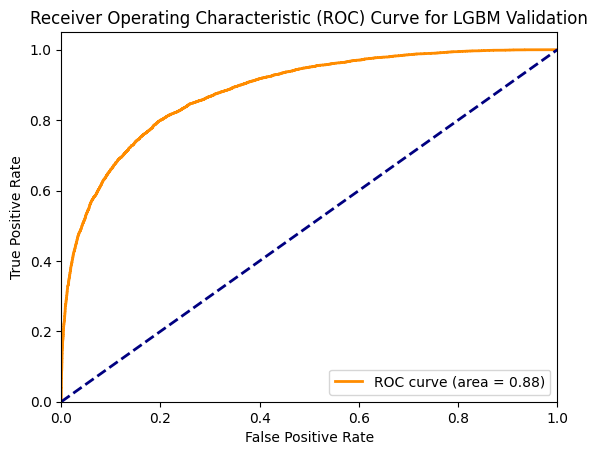

In [15]:
compute_auroc_and_build_roc(lgbm, X_test, test_targets, name='LGBM Validation')

Precision score: 0.75
Recall score: 0.44
F1 score: 0.55


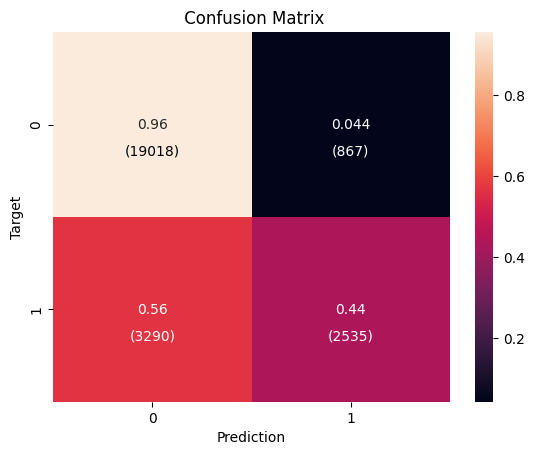

In [44]:
compute_metrics(rf, X_test, test_targets, threshold=rf_threshold)

Precision score: 0.74
Recall score: 0.45
F1 score: 0.56


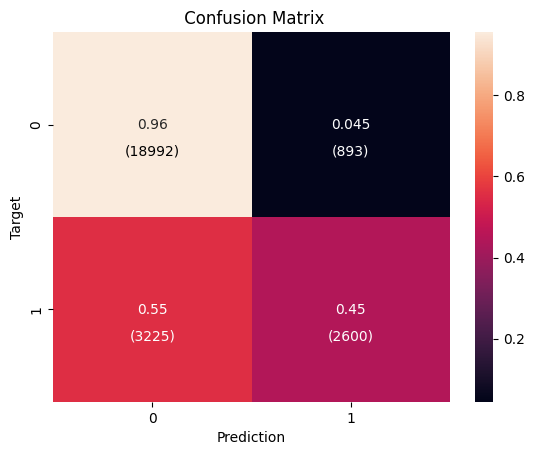

In [45]:
compute_metrics(xgb, X_test, test_targets, threshold=xgb_threshold)

Precision score: 0.74
Recall score: 0.47
F1 score: 0.58


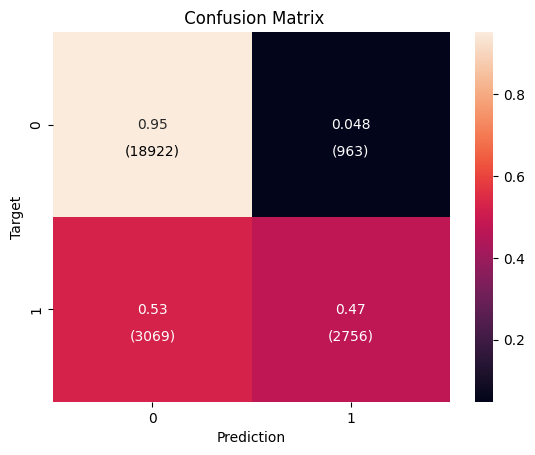

In [43]:
compute_metrics(lgbm, X_test, test_targets, threshold=lgbm_threshold)

# Saving the best model

In [16]:
aussie_rain = {
    'model': lgbm,
    'imputer': imputer,
    'scaler': scaler,
    'encoder': encoder,
    'input_cols': input_cols,
    'target_col': target_col,
    'numeric_cols': numeric_cols,
    'categorical_cols': categorical_cols
}

In [31]:
joblib.dump(aussie_rain, '/aussie_rain.joblib', compress=('zlib', 3))

['aussie_raint.joblib']